In [2]:
import torch
import copy
from torch import nn
from torch.nn.utils.rnn import pack_sequence
from collections import Counter
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torch import utils
from functools import partial
from sklearn.model_selection import train_test_split
import numpy as np
import time
import itertools

In [7]:
class LanguageDataset(utils.data.Dataset):
    
    def __init__(self, directory):
        all_chars = set()
        lang_names = {}
        language_files = os.listdir(directory)
        for i, file in enumerate(language_files):
            if not file.endswith("txt"):
                continue
            language = os.path.splitext(os.path.basename(file))[0]
            with open(os.path.join(directory, file)) as f:
                content = f.read().strip().lower()
                all_chars.update(content)
                names = content.split("\n")
                lang_names[language] = names
        all_chars.discard("\n")
        self.ix_to_char = dict(enumerate(all_chars))
        self.char_to_ix = {char : ix for ix, char in self.ix_to_char.items()}
        self.ix_to_lang = dict(enumerate(lang_names))
        self.lang_to_ix = {lang : ix for ix, lang in self.ix_to_lang.items()}
        
        self.dataset = []
        for lang, names in lang_names.items():
            for name in names:
                lang_tensor = self.lang_to_tensor(lang)
                name_tensor = self.name_to_tensor(name)
                self.dataset.append((name_tensor, lang_tensor))
                
    def lang_to_tensor(self, lang):
        return torch.tensor(self.lang_to_ix[lang])
    
    def name_to_tensor(self, name):
        return torch.tensor([self.char_to_ix[char] for char in name])
    
    def tensor_to_name(self, tensor, one_hot=False):
        if one_hot:
            return "".join((self.ix_to_char[int(ix)] for ix in torch.argmax(tensor, dim=1)))
        else:
            return "".join((self.ix_to_char[int(ix)] for ix in tensor))
        
    def tensor_to_lang(self, tensor, probs=False):
        if probs:
            tensor = torch.argmax(tensor)
        return self.ix_to_lang[int(tensor)]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index]

In [11]:
split = 0.1
dataset = LanguageDataset("data/names")

y_val = [y for _, y in dataset]
train_indices, val_indices = train_test_split(np.arange(len(dataset)), test_size=split, stratify=y_val)
train_data = utils.data.Subset(dataset, indices=train_indices)
val_data = utils.data.Subset(dataset, indices=val_indices)

In [13]:
len(train_data), len(val_data)

(17826, 1981)

Counter class imbalance by oversampling underrepresented classes

In [14]:
class_counts = Counter([int(val) for _, val in dataset.dataset])
weights = {key: 1 / val for key, val in class_counts.items()}
train_weights = [weights[int(val)] for _, val in train_data]
val_weights = [weights[int(val)] for _, val in val_data]

train_sampler = utils.data.WeightedRandomSampler(train_weights, len(train_weights), True)
val_sampler = utils.data.WeightedRandomSampler(val_weights, len(val_weights), True)

In [15]:
def get_n_val_samples(n):
    it = iter(val_sampler)
    for i in range(n):
        ix = next(it)
        yield val_data[ix][0], val_data[ix][1]

Have a look at some validation data:

In [16]:
for x, y in get_n_val_samples(20):
    print(f"{dataset.tensor_to_name(x).capitalize():13}: {dataset.tensor_to_lang(y)}")

Bautista     : Spanish
Arendonk     : Dutch
Svocak       : Czech
Rheem        : Korean
Paget        : French
Zhui         : Chinese
Accorso      : Italian
Yeung        : English
Botros       : Arabic
Dmokhovsky   : Russian
Rompay       : Dutch
Haibullin    : Russian
Bellerose    : French
Yakunov      : Russian
Lang         : Chinese
Kosko        : Czech
Ming         : Chinese
Mogilevich   : Russian
Jeong        : Korean
Gudoshin     : Russian


Define the model

In [17]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    # `x` is PackedSequence, `lengths` contains lengths of sequences in `x`.
    def forward(self, x, lengths):
        rnn_out, _ = self.rnn(x)
        # https://discuss.pytorch.org/t/get-each-sequences-last-item-from-packed-sequence/41118/7
        sum_batch_sizes = torch.cat((
            torch.zeros(2, dtype=torch.int64),
            torch.cumsum(rnn_out.batch_sizes, 0)
        ))
        sorted_lengths = lengths[rnn_out.sorted_indices]
        last_seq_idxs = sum_batch_sizes[sorted_lengths] + torch.arange(lengths.size(0))
        last_seq_items = rnn_out.data[last_seq_idxs]
        rnn_last_out = last_seq_items[rnn_out.unsorted_indices]
        linear_out = self.linear(rnn_last_out)
        softmax_out = self.softmax(linear_out)

        return softmax_out

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Define training and helper functions

In [19]:
def my_collate(batch, input_size, output_size):
    lengths = torch.tensor([len(item[0]) for item in batch])
    data = [item[0] for item in batch]
    targets = torch.tensor([item[1] for item in batch])
    return data, targets, lengths

def indices_to_packed(names, input_size):
    names = [F.one_hot(item, input_size).float() for item in names]
    names_packed = pack_sequence(names, enforce_sorted=False)
    return names_packed

def infer_and_loss(model, data, labels, lengths, device):
    data_packed = indices_to_packed(data, model.rnn.input_size)
    data_packed, labels, lengths = data_packed.to(device), labels.to(device), lengths.to(device)
    preds = model(data_packed, lengths)
    loss = loss_fn(preds, labels)
    return loss, preds

def get_loader(dataset, batch_size, sampler):
    return utils.data.DataLoader(
        dataset, 
        batch_size, 
        sampler=sampler, 
        collate_fn=partial(my_collate, input_size=input_size, output_size=output_size)
    )

def train(num_layers, hidden_size, batch_size, epochs):
    train_loader = get_loader(train_data, batch_size, train_sampler)
    val_loader = get_loader(val_data, batch_size, val_sampler)
    model = RNN(input_size, hidden_size, num_layers, output_size)
    optimizer = torch.optim.AdamW(model.parameters())
    model.to(device)

    train_losses = []
    accuracies = []
    metrics = {}
    duration = 0
    best_accuracy = 0
    wait = 1
    for epoch in range(epochs):
        start = time.time()
        train_loss = 0
        model.train()
        for names, langs, lengths in train_loader:
            optimizer.zero_grad()
            loss, _ = infer_and_loss(model, names, langs, lengths, device)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(names)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        accuracy = 0
        lengths_check = 0
        with torch.no_grad():
            for names, langs, lengths in val_loader:
                _, preds = infer_and_loss(model, names, langs, lengths, device)
                preds = torch.argmax(preds, dim=1)
                accuracy += (preds == langs).sum().float()

        accuracy /= len(val_loader.dataset)
        accuracies.append(accuracy)

        cur_duration = time.time() - start
        duration += cur_duration
        
        log_line = (f"NUM_LAYERS: {num_layers}, HIDDEN_SIZE: {hidden_size}, "
                    f"BATCH_SIZE: {batch_size}, " 
                    f"epoch: {epoch}, train loss: {train_loss:.5f}, "
                    f"accuracy: {accuracy:.5f}")
        print(log_line)
        
        # Early stopping
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = copy.deepcopy(model)
            wait = 1
        else:
            if wait >= PATIENCE:
                break
            wait += 1
        
    metrics["train_losses"] = train_losses
    metrics["accuracies"] = accuracies
    return {"metrics" : metrics, "duration" : duration, "model": best_model}

In [20]:
input_size = len(dataset.char_to_ix)
output_size = len(dataset.lang_to_ix)
loss_fn = torch.nn.NLLLoss()

If you want to run hyperparameter grid search yourself, uncomment the values in PARAMS

In [21]:
# Perform a grid search of parameters and choose best model based on validation accuracy
EPOCHS = 100
PATIENCE = 20
results = {}
best_acc = 0
PARAMS = {
    "num_layers": [1], # [1, 2]
    "hidden_size": [64], # [32, 64, 128]
    "batch_size": [64] # [16, 64, 256]
}

params_product = list(itertools.product(*PARAMS.values()))
for i, (num_layers, hidden_size, batch_size) in enumerate(params_product):
    print((i + 1)/len(params_product))
    res = train(num_layers, hidden_size, batch_size, EPOCHS)
    results[(num_layers, hidden_size, batch_size)] = res
    accuracy = max(res["metrics"]["accuracies"])
    if accuracy > best_acc:
        best_model = res["model"]
        best_acc = accuracy 

1.0
NUM_LAYERS: 1, HIDDEN_SIZE: 64, BATCH_SIZE: 64, epoch: 0, train loss: 2.28104, accuracy: 0.39929
NUM_LAYERS: 1, HIDDEN_SIZE: 64, BATCH_SIZE: 64, epoch: 1, train loss: 1.62383, accuracy: 0.49369
NUM_LAYERS: 1, HIDDEN_SIZE: 64, BATCH_SIZE: 64, epoch: 2, train loss: 1.38358, accuracy: 0.51186
NUM_LAYERS: 1, HIDDEN_SIZE: 64, BATCH_SIZE: 64, epoch: 3, train loss: 1.26078, accuracy: 0.55528
NUM_LAYERS: 1, HIDDEN_SIZE: 64, BATCH_SIZE: 64, epoch: 4, train loss: 1.18207, accuracy: 0.58354
NUM_LAYERS: 1, HIDDEN_SIZE: 64, BATCH_SIZE: 64, epoch: 5, train loss: 1.10607, accuracy: 0.58758
NUM_LAYERS: 1, HIDDEN_SIZE: 64, BATCH_SIZE: 64, epoch: 6, train loss: 1.04435, accuracy: 0.59970
NUM_LAYERS: 1, HIDDEN_SIZE: 64, BATCH_SIZE: 64, epoch: 7, train loss: 0.99667, accuracy: 0.58607
NUM_LAYERS: 1, HIDDEN_SIZE: 64, BATCH_SIZE: 64, epoch: 8, train loss: 0.96071, accuracy: 0.57799
NUM_LAYERS: 1, HIDDEN_SIZE: 64, BATCH_SIZE: 64, epoch: 9, train loss: 0.90498, accuracy: 0.59515
NUM_LAYERS: 1, HIDDEN_SIZE

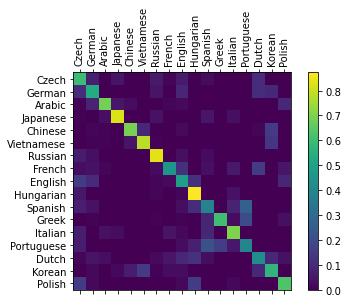

In [22]:
confusion = torch.zeros(output_size, output_size)
val_loader = get_loader(val_data, len(val_data), val_sampler)
with torch.no_grad():
    names, langs, lengths = next(iter(val_loader))
    _, preds = infer_and_loss(best_model, names, langs, lengths, device)
    preds = torch.argmax(preds, dim=1)
    for pred, truth in zip(preds, langs):
        confusion[pred][truth] += 1

for i in range(output_size):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(confusion)
fig.colorbar(cax)

ixs = list(dataset.ix_to_lang.keys())
ax.set_xticks(ixs)
ax.set_yticks(ixs)
keys = list(dataset.lang_to_ix.keys())
ax.set_xticklabels(keys, rotation=90)
ax.set_yticklabels(keys)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

In [14]:
def predict(name, model, device, n_predictions=3, is_tensor=False):
    with torch.no_grad():
        if not is_tensor:
            name_tensor = dataset.name_to_tensor(name)
        else:
            name_tensor = name
        names_packed = indices_to_packed([name_tensor], input_size).to(device)
        output = model(names_packed, torch.tensor(name_tensor.shape))
        topv, topi = output.topk(n_predictions, 1, True)
        preds = {topi[0][i]: torch.exp(topv[0][i]) for i in range(n_predictions)}
        return preds

Now let's examine some concrete predictions

In [16]:
for name, lang in get_n_val_samples(10):
    name_readable = dataset.tensor_to_name(name).capitalize()
    lang_readable = dataset.tensor_to_lang(lang)
    print(f"{name_readable:13}: {lang_readable}")
    preds = predict(name, best_model, device, is_tensor=True)
    print("Predictions:")
    preds_l = [f"{dataset.tensor_to_lang(lang_pred):13}: {prob:.2f}" for lang_pred, prob in preds.items()]
    preds_s = "\n".join(preds_l)
    print(preds_s)
    print()

Antwerp      : Dutch
Predictions:
Dutch        : 0.89
English      : 0.05
German       : 0.04

Tian         : Chinese
Predictions:
Vietnamese   : 0.69
Chinese      : 0.29
French       : 0.01

Quattrocchi  : Italian
Predictions:
Italian      : 0.85
Polish       : 0.07
Russian      : 0.03

Trinh        : Vietnamese
Predictions:
Vietnamese   : 0.91
German       : 0.05
English      : 0.03

Eliopoulos   : Greek
Predictions:
Greek        : 1.00
Spanish      : 0.00
Italian      : 0.00

Basurto      : Portuguese
Predictions:
Spanish      : 0.51
Italian      : 0.43
Russian      : 0.03

Komine       : Japanese
Predictions:
Japanese     : 0.49
Dutch        : 0.22
English      : 0.08

Nose         : Japanese
Predictions:
French       : 0.50
Italian      : 0.19
English      : 0.11

Deforest     : French
Predictions:
French       : 0.81
Dutch        : 0.05
English      : 0.05

Sokal        : Polish
Predictions:
Polish       : 0.65
Czech        : 0.28
Hungarian    : 0.05

